Install torchprofile :)

In [1]:
##!pip install torchprofile 

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import *
from torch.optim.lr_scheduler import *
from torchprofile import profile_macs

import torchvision
from tqdm.auto import tqdm

Set random seed

In [12]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### **1. Data processing**

#### **1.1 Create Transfoms**

In [13]:
from torchvision import transforms
from torchvision import datasets 
transforms = {
    "train": transforms.Compose([
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    "test": transforms.ToTensor()
}

dataset = {}
for split in ["train","test"]:
    dataset[split] = datasets.CIFAR10(
        root = "data/cifar10",
        train=(split=="train"),
        download=True,
        transform= transforms[split]
    )

Files already downloaded and verified
Files already downloaded and verified


**Visualize few data samples**

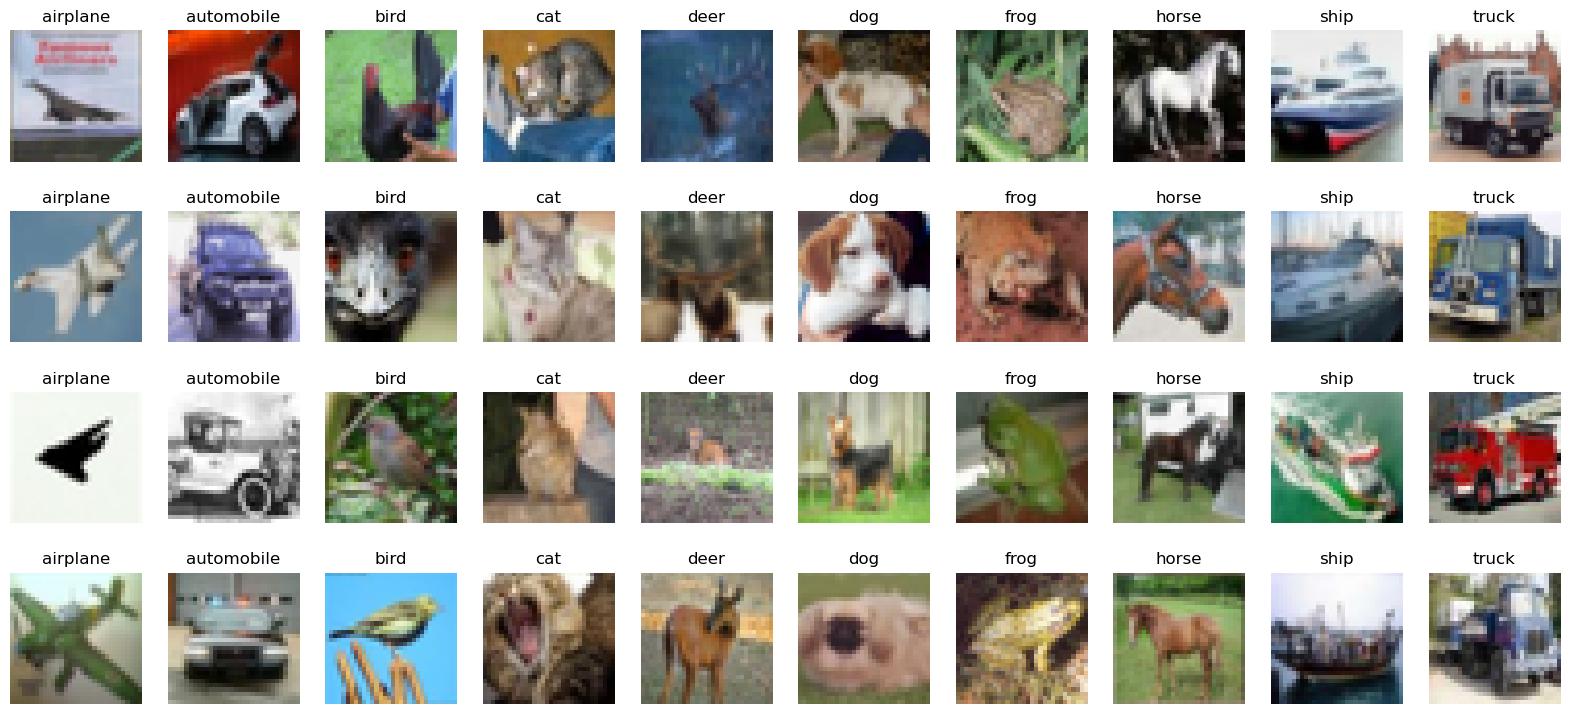

In [14]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
    if len(samples[label]) < 4:
        samples[label].append(image)
plt.figure(figsize=(20,9))
for index in range(40):
    label = index%10
    image = samples[label][index//10]
    
    #Convert from XHW to HWC for matplotlib
    image = image.permute(1,2,0)
    
    # Convert from class index to class name
    label = dataset["test"].classes[label]
    
    #Visualize image
    plt.subplot(4,10,index+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
    
plt.show()
    

**1.2 Create DataLoaders**

In [19]:
BATCH_SIZE = 512
NUM_WORKERS = 0

dataflow = {}
for split in ["train","test"]:
    dataflow[split]=DataLoader(
        dataset=dataset[split],
        batch_size=BATCH_SIZE,
        shuffle=(split=="train"),
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
for inputs, targets in dataflow["train"]:
    print("[inputs]  dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
    print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
    break

[inputs]  dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


### **2. Model**

#### **Define VGG-11 Architecture**

VGGV : https://arxiv.org/abs/1409.1556

In [31]:
class VGG11(nn.Module):
    ARCH = [64,128,'M',256,256,'M',512,512,'M',512,512,'M']
    
    def __init__(self)->None:
        super().__init__()
        
        layers = []
        counts = defaultdict(int)
        
        def add (name:str, layer: nn.Module) ->None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name]+=1
            
        in_channels = 3
        for x in self.ARCH:
            if x!='M':
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x
            else:
                add("pool", nn.MaxPool2d(2 ))
                
        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512,10)
        
    def forward(self, X : torch.Tensor) -> torch.Tensor:
        X = self.backbone(X)
        X = X.mean([2,3]) # Avgpool
        X = self.classifier(X)
        return X
                
    
        

**Set device agnostic code**

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
model = VGG11().to(device)

In [36]:
print(model.backbone)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [37]:
model.classifier

Linear(in_features=512, out_features=10, bias=True)

**~ Model size**

In [39]:
num_params = 0
for param in model.parameters():
    if param.requires_grad:
        num_params+= param.numel()
print(f"Trainable Parameters {num_params}")
        

Trainable Parameters 9228362


**~ MACs (Multiply-accumulate operations) using `TorchProfile`**

In [43]:
num_macs = profile_macs(model, torch.zeros(1,3,32,32).to(device))
print(f"MACs : {num_macs}")

MACs : 606164480


### **3. Training**

#### 3.1 Define Optimizer and loss function

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(
    model.parameters(),
    lr=0.4,
    momentum=0.9,
    weight_decay=5e-4,
)

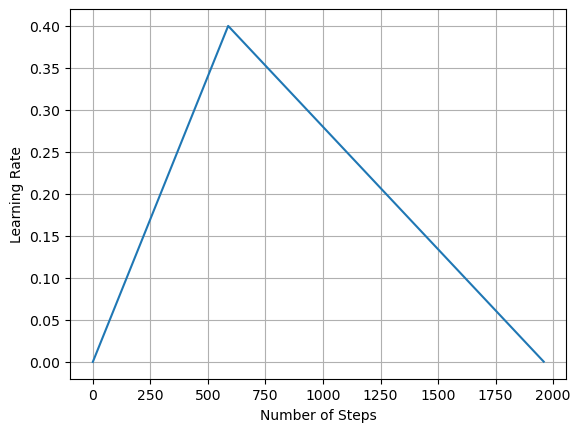

In [48]:
num_epochs = 20
steps_per_epoch = len(dataflow["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],
  [0, 1, 0]
)[0]

# Visualize the learning rate schedule
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

#### **3.2 Define training funtion**

In [51]:
def train(
    model:nn.Module,
    dataflow:DataLoader,
    loss_fn:nn.Module,
    optimizer:Optimizer,
    scheduler:LambdaLR,
)-> None:

    # Set model to training mode
    model.train()
    
    for inputs, targets in tqdm(dataflow, desc="train", leave=False):
        # Mode data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 1. Forward pass
        y_preds = model(inputs)
        
        # 2. Calculate the loss
        loss = loss_fn(y_preds, targets)
        
        # 3. optimizer zero grad : Reset the gradients
        optimizer.zero_grad()
        
        # 4. loss.backward
        loss.backword()
        
        # 5. Optimizer step
        optimizer.step()
        scheduler.step()

In [52]:
def evaluate(
    model:nn.Module,
    dataflow:DataLoader ) -> float:
    
    # set model to evaluation mode
    model.eval()
    
    num_samples=0
    num_correct=0
    
    for inputs, targets in tqdm(model, desc="eval", leave=False):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Inference : Prediction logits
        preds = model(inputs)
        
        # convert prediction logits to class indices
        classIdx = preds.argmax(dim=1)
        
        #update metrics
        num_samples += targets.size(0)
        num_correct += (classIdx==targets).sum()
        
    return (num_correct/num_samples*100).item()
        

In [54]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
    train(model, dataflow["train"], loss_fn, optimizer, scheduler)
    metric = evaluate(model, dataflow["test"])
    print(f"epoch {epoch_num}:", metric)

  0%|          | 0/20 [00:06<?, ?it/s]       


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 134217728 bytes.